# Data Pipeline

Maintained by: <br>
    Sam Tosaria
    
### Purpose:

This notebook walks through the data pipeline and the import methods used to set up the data, along with a small proof of concept (pipeline methodology verification) model.

Downloads ~23K USA 2005 LANDSAT image files corresponsing with the UN GMIA data at 30M resolution - 10km x 10km tiles.  


#### NOTE:
PLease DO NOT train the model or use the model output. The TF One-hot encoder did not function as expected. This is amended in the full use models located in the Github /models/ folder 



In [ ]:
# !pip install geopandas -- quiet
# !pip install rasterio -- quiet
# !pip install tensorflow==2.1.0 -q

In [15]:
from time import sleep
import sys
import tensorflow as tf
print('Tensorflow version: ',tf.__version__)
import numpy as np
from google.colab import drive
import ee
from IPython.display import Image
from tensorflow.keras import datasets, layers, models, Input
import matplotlib.pyplot as plt
from pprint import pprint
from random import shuffle
import scipy.ndimage

# import ee.mapclient
# import folium
# from shapely.geometry import Polygon, MultiPolygon
# import fiona
# import geopandas as gpd

# Import the Image function from the IPython.display module. 


Tensorflow version:  2.2.0


In [ ]:
# Increase the default Colab recursion limit to setup up a larger shard for data export from Google Earth Engine (GEE).
sys.setrecursionlimit(6_000)

In [16]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import GMIA tile IDs

This is a class balanced representation of the US GMIA data

In [17]:
TRAIN_ID = '/content/drive/My Drive/W210/eq_train_set'
TEST_ID = '/content/drive/My Drive/W210/test_set'

In [18]:
#WARNING - You must be registered with GEE to proceed
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=__nSiEgKlSj8q-TqsVPPMfGsb1HVasVouv_HXkcWmg4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1gHo23TZNAIkpR0z2ORIoceeKcvbs_-Vn87JFTqk9ZP-DmYOeVne2UM

Successfully saved authorization token.


In [21]:
#Setup the GCP cloud bucket access for data import/export

PROJECT_ID = 'w210project'
GCP_BUCKET = 'w210gee_data'
!gcloud config set project {PROJECT_ID}
FOLDER='tensors'

DRIVE_OUTPUT_FOLDER = '/Colab Notebooks/w210_project/data/tf_output'

print('\nFound Cloud Storage bucket.\n' if tf.io.gfile.exists('gs://' + GCP_BUCKET) 
    else 'Output Cloud Storage bucket does not exist.')

Updated property [core/project].

Found Cloud Storage bucket.



In [ ]:
#Global variable for data export and model training.


opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'] #, 'B6_VCID_1', 'B6_VCID_2'
BANDS = opticalBands
RESPONSE = 'landcover'
TARGET = 'target'
EPSILON = 0.000001
NCLASSES = 6
TRAIN_PREFIX = 'train'
TEST_PREFIX = 'test'
TRAIN_SIZE = 1520 + 108 + 1037 + 290 + 1520 + 3382 + 2831
TEST_SIZE = 600
BUFFER_SIZE = 500
BATCH_SIZE = 10
EPOCH = 10



---



---



---



---



---



---



## GEE image setup

Data calls in GEE work on a Map-Reduce framework.

First we will setup the specifications of the image we need, then we will extract the image based on the coordinate reseference system metadata attached to the tile ID which has been imported into GEE as a `GEE Asset`. The metadata attached is displayed further down in this notebook.



1.  Get the Landsat image filtered by the image type (SR, TOA).
2.  Filter by dates and season.
3.  Remove pixels with clouds and cloud shadows, reduce to decimals.


Next we layer on the GFSAD data filtered for irrigation land classification (1-5). The remaining and cropland classifications, which we will ignore for this analysis.


In [24]:
summer = ee.Filter.calendarRange(6,8, 'month')

def maskL7sr(image):
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
    mask2 = image.mask().reduce('min')
    mask3 = image.select(opticalBands).gt(0).And(
            image.select(opticalBands).lt(10000)).reduce('min')
    mask = mask1.And(mask2).And(mask3)
    # mask = mask2.And(mask3)
    return image.select(BANDS).divide(10000).updateMask(mask)

ls7_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')\
            .filterDate('2004-01-01','2007-12-31')\
            .filter(summer)\
            .map(maskL7sr)\
            .median()
            # .select(BANDS)\

gfsad = ee.Image('USGS/GFSAD1000_V1')\
            .select(RESPONSE)\
            
cropland = gfsad.updateMask(gfsad.lte(5)) #.And(gfsad.gt(0))

In [25]:
# ls7_img.getInfo()
cropland.getInfo()['properties']['landcover_class_values']

[0, 1, 2, 3, 4, 5]

Stack the bands and the GFSAD classification.

In [26]:
stacked_img = ee.Image.cat([ls7_img.select(BANDS),
                            cropland.select(RESPONSE)
                           ]).float()

### GEE Image --> Coordinate Referenced Image


Here we take the `GEE Asset` with GMIA information and filter it by the GMIA tile ID and obtain a `JSON` object.

For example -- 


In [27]:
pprint(ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final')\
            .filter(ee.Filter.eq('ID', int(222486))).getInfo()['features'][0])

{'geometry': {'coordinates': [[[-100.08333260427784, 33.99999895237805],
                               [-100.04166674037944, 33.999998954479935],
                               [-100.00000086842455, 33.9999989901469],
                               [-100.00000086842455, 34.08333511923997],
                               [-100.04166674037944, 34.08333512917782],
                               [-100.08333260427784, 34.083335057969286],
                               [-100.08333260427784, 33.99999895237805]]],
              'type': 'Polygon'},
 'id': '00050000000000004554',
 'properties': {'ID': 222486,
                'PCT_AEI': 0.14,
                'bins': 0,
                'continent': 'North America',
                'index_righ': 4,
                'iso_a3': 'USA',
                'name': 'United States of America'},
 'type': 'Feature'}




<br>

Next, we extract the coordinate reference from the JSON object and convert it into a `GEE Geometery Polygon` object.

Then we clip the image to that referenced geometry and provide an image size. 

<br>
<br>

How do we chose the image size and why is it a non-standard 309 x 309 size?

GMIA tiles are `5-Minute Arc`, or 9.25 kms. x 9.25 kms.

> <font size="2"> Source http://www.fao.org/aquastat/en/geospatial-information/global-maps-irrigated-areas/latest-version/</font> 

Lets walk through the math, at 9,250 meters, with the best native resolution of the LANDSAT 7/8 image of 30 meters per pixel:

> 9250 / 30 = 308.33 pixels.

For a 256 x 256 image pixels the GEE `clipToBoundAndScale` function should output a 36 meter per pixel image.



In [29]:
# 167463 SAN FERNANDO VALLEY 92.69%
# 180748 SF 2.5%
# 179769
# 184796

shp_json = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final')\
            .filter(ee.Filter.eq('ID', 180748)).getInfo()

geom = ee.Geometry.Polygon(shp_json['features'][0]['geometry']['coordinates'])

img_array = ls7_img.clipToBoundsAndScale(geom, 309, 309)



Image Resolution:

In [30]:
b1scale = img_array.select('B1').projection().nominalScale()
print('Band 1 scale: \n', int(b1scale.getInfo()))

Band 1 scale: 
 30


Use Ipython's `Image` function to display the image in notebook with an increase 1024 resolution so a human eye can see the pixel level details.

In [31]:
Image(url = img_array.getThumbUrl({'bands':['B3','B2','B1'], 
                                    'min': 0, 'max':0.25, 'dimensions':'1024x1024'
                                   }))



<br>
<br>

Now let's create a 256 x 256 image at 36 meter per pixel resolution for comparison, and confirm the image resolution and our calculation.

In [33]:
img_array = ls7_img.clipToBoundsAndScale(geom, 256, 256)

b1scale = img_array.select('B1').projection().nominalScale()
print('Band 1 scale: \n', int(b1scale.getInfo()))



Band 1 scale: 
 36


In [34]:
Image(url = img_array.getThumbUrl({'bands':['B3','B2','B1'], 
                                    'min': 0, 'max':0.25, 'dimensions':'1024x1024'
                                   }))

## Visual Proof of Image Resolution

A 30 meter by 30 meter resolution pixel is about the size of a baseball diamond.

NASA compares the Landsat image of Target Field Baseball Stadium in Minneapolis with an arieal picture of the stadium. 

We can look at the pictures of San Fransisco above and look at the track and field stadium in the Golden Gate Park (bottom left, long green strip) and eyeball the measurement for visual confirmation.


> <font size="2"> Source: https://landsat.gsfc.nasa.gov/picturing-a-pixel/ </font>









---



---



---



---



---



---



# Image Export to GCP Cloud Bucket


GEE does not allow bulk export of images. This was a significant impedement in this project.

<br>

However there is a workaround:

1. Convert the images into `GEE Array` objects ie Numpy arrays.
2. Stack the Numpy arrays into a `GEE FeatureCollection` object.
3. Export the collection as a GZIP TFRecord file.


LIMIT: The GZIP files bigger than 200MB seem to fail in the creation and export phase, while not returning an error message.

We figured out this limitation by trial and error.

We will break the ID list into multiple sets and shard the records to ~ 300 images ~= 200 MB GZIP files.


In [ ]:
#Read in the list of IDs to export

with open(TRAIN_ID, mode='r') as file:
    train_ids = list(map(int, file.readlines()))
shuffle(train_ids)
print(train_ids[:5])
print(len(train_ids))

[130013, 119725, 94288, 176068, 115715]
12685


In [ ]:
with open(TEST_ID, mode='r') as file:
    test_ids = list(map(int, file.readlines()))
shuffle(test_ids)
test_ids[:5]

[88890, 117640, 228646, 185988, 115738]

In [ ]:
#Create smaller sublists to manage the data 
#before sharding it into ~200MB compressed files.


#Create 4 splits for the file
tile_shards = np.array_split(train_ids, 4)
train0 = tile_shards[0]
train1 = tile_shards[1]
train2 = tile_shards[2]
train3 = tile_shards[3]

print(len(train1))

3171


In [ ]:
# Create 11 shards with each containing ~300 IDs
tile_shards = np.array_split(train3, 11)

#### Sample Test Case

The tile export will sets of shards with multiple tile IDs, split using numpy array split function.

A nested `for` loop with first loop iterating over the shards, and the second cycling through the tile IDs

In [ ]:
#Test case
tile_shards = np.array_split(test_ids, 2)

In [ ]:
# Test case for nested shards and tile ID loop
for shard in range(len(tile_shards)):
    for tile_id in tile_shards[shard]:
        print(tile_id)
        print(shard)
        break

82820
0
247319
1


### Array Export : Using Python List of Tile IDs

<br>

Here we clip the image and the apply the `sampleRectangle` function to the image which will convert the image into arrays. The pixels which are dissected are assigned a default 0 value.

Then we attach the metadata from the `GEE Asset` to the record, collate all the records in the shard, compress and export it to the cloud folder.

In [ ]:
for shard in range(len(tile_shards)):
    geomSample = ee.FeatureCollection([])

    for tile_id in tile_shards[shard]:
        tile_json = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final')\
                    .filter(ee.Filter.eq('ID', int(tile_id))).getInfo()['features'][0]
        geom = ee.Geometry.Polygon(tile_json['geometry']['coordinates'])
        target = tile_json['properties']['bins']/100.0
        aei = tile_json['properties']['PCT_AEI']
        id = tile_json['properties']['ID']
        img_array = stacked_img.clipToBoundsAndScale(geom, 256, 256)\
                                .sampleRectangle(**{'defaultValue':0.0})\
                                .set({'target':target})\
                                .set({'aei':aei})\
                                .set({'id':id})

        geomSample = geomSample.merge(img_array)

    desc = 'train_US_{}_{}'.format('E3', shard)
    ee.batch.Export.table.toCloudStorage(**{
            'collection':geomSample,
            'description':desc, 
            'bucket':GCP_BUCKET, 
            'fileNamePrefix':FOLDER + '/' + desc,
            'fileFormat':'TFRecord'
            }).start()

### Image Export Scratch Pad

In [ ]:
# for shard in range(len(tile_shards)):
#     geomSample = ee.FeatureCollection([])

#     for tile_id in tile_shards[shard]:
#         tile_json = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final')\
#                     .filter(ee.Filter.eq('ID', int(tile_id))).getInfo()['features'][0]
#         geom = ee.Geometry.Polygon(tile_json['geometry']['coordinates'])
#         target = tile_json['properties']['bins']/100.0
#         aei = tile_json['properties']['PCT_AEI']
#         id = tile_json['properties']['ID']
#         img_array = stacked_img.clipToBoundsAndScale(geom, 256, 256)\
#                                 .sampleRectangle(**{'defaultValue':0.0})\
#                                 .set({'target':target})\
#                                 .set({'aei':aei})\
#                                 .set({'id':id})

#         geomSample = geomSample.merge(img_array)

#     desc = 'test_US_{}_{}'.format('EQ', shard)
#     ee.batch.Export.table.toCloudStorage(**{
#             'collection':geomSample,
#             'description':desc, 
#             'bucket':GCP_BUCKET, 
#             'fileNamePrefix':FOLDER + '/' + desc,
#             'fileFormat':'TFRecord'
#             }).start()

## Array Export : Alternative Approach 

###1. Using GEE Asset Filter (by Tile ID)


    We can filter the tile IDs using the metadata attached to the `GEE Asset` .

    For example, here we filter the data using the tile IDs ( we can use state or country or other metadata fields as well, see the payload properties below).

    This returns a GEE `FeatureCollection`.


In [ ]:
#Test case
tile_stack = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final')\
            .filter(ee.Filter.gte('ID', 174075))\
            .filter(ee.Filter.lte('ID', 174100)) #174100

In [ ]:
tile_stack.first().getInfo()

{'geometry': {'coordinates': [[[-103.16666717523141, 42.91666712193548],
    [-103.12500129554506, 42.916667127067974],
    [-103.08333549574438, 42.916667111158596],
    [-103.08333549574438, 42.9999987949507],
    [-103.12500129554506, 42.99999883961],
    [-103.16666717523141, 42.999998833309384],
    [-103.16666717523141, 42.91666712193548]]],
  'type': 'Polygon'},
 'id': '00000000000000009748',
 'properties': {'ID': 118642,
  'PCT_AEI': 0,
  'STUSPS': 'NE',
  'bins': 0,
  'continent': 'North America',
  'index_r': 17,
  'iso_a3': 'USA',
  'name': 'United States of America'},
 'type': 'Feature'}

<br>



Then we covert the filtered GEE `FeatureCollection` into a `GEE List`.

<br>

Note this is not the same as a Python List.

<br>


Here we iterate through a range of the size of the `GEE List` and carry out the same operation as above.

In [ ]:
list_tile_stack = tile_stack.toList(tile_stack.size())
tot_tiles = np.array(range(tile_stack.size().getInfo()))
tile_shards = np.array_split(tot_tiles, 1)

geomSample = ee.FeatureCollection([])

for feat in range(tile_stack.size().getInfo()):
    rec_info = list_tile_stack.get(feat).getInfo()
    geom = ee.Geometry.Polygon(rec_info['geometry']['coordinates'])
    target = rec_info['properties']['bins']/100.0
    aei = rec_info['properties']['PCT_AEI']

    img_array = stacked_img.clipToBoundsAndScale(geom, 256, 256)\
                        .sampleRectangle(**{'defaultValue':0.0})\
                        .set({'target':target})\
                        .set({'aei':aei})

    geomSample = geomSample.merge(img_array)

desc = 'train_US_{}_{}'.format('test', 'case2')
task1  = ee.batch.Export.table.toCloudStorage(**{
        'collection':geomSample,
        'description':desc, 
        'bucket':GCP_BUCKET, 
        'fileNamePrefix':FOLDER + '/' + desc,
        'fileFormat':'TFRecord',
        })
task1.start()

In [ ]:
#Check task status
# WARNING - CANNOT start multiple tasks with the same name.
# Must wait till task completion or use an iterator to create unique task names.
task1.status()

{'creation_timestamp_ms': 1583422297382,
 'description': 'train_US_test_collapseBands',
 'id': 'D3B5I3TYP7JA7WVAPGHLWZ6W',
 'name': 'projects/earthengine-legacy/operations/D3B5I3TYP7JA7WVAPGHLWZ6W',
 'start_timestamp_ms': 1583422315988,
 'state': 'CANCEL_REQUESTED',
 'task_type': 'EXPORT_FEATURES',
 'update_timestamp_ms': 1583422405357}

## Array Export : Alternative Approach 

###2. Using GEE Asset Filter (by State)


In [ ]:

cen_cal = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_us')\
            .filter(ee.Filter.eq('STUSPS', 'ME'))

In [ ]:
# states = ['SC']
state_code='LA'
SPLITS=4

In [ ]:

tile_stack = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_us')\
                .filter(ee.Filter.eq('STUSPS', state_code))

list_tile_stack = tile_stack.toList(tile_stack.size())
tot_tiles = np.array(range(tile_stack.size().getInfo()))
tile_shards = np.array_split(tot_tiles, SPLITS)

for shard in range(len(tile_shards)):
    geomSample = ee.FeatureCollection([])

    for feat in tile_shards[shard]:
        rec_info = list_tile_stack.get(int(feat)).getInfo()
        geom = ee.Geometry.Polygon(rec_info['geometry']['coordinates'])
        target = rec_info['properties']['bins']/100.0
        aei = rec_info['properties']['PCT_AEI']
        id = rec_info['properties']['ID']

        img_array = stacked_img.clipToBoundsAndScale(geom, 256, 256)\
                            .sampleRectangle(**{'defaultValue':0.0})\
                            .set({'target':target})\
                            .set({'aei':aei})\
                            .set({'id':id})

        geomSample = geomSample.merge(img_array)

    desc = 'train_US_{}_{}'.format(state_code, shard)
    ee.batch.Export.table.toCloudStorage(**{
            'collection':geomSample,
            'description':desc, 
            'bucket':GCP_BUCKET, 
            'fileNamePrefix':FOLDER + '/' + desc,
            'fileFormat':'TFRecord'
            }).start()

In [ ]:
# task.status()

{'creation_timestamp_ms': 1583432290464,
 'description': 'train_US_MA_0',
 'destination_uris': ['https://console.developers.google.com/storage/browser/w210gee_data/tensors/'],
 'id': 'QTJ2JDVNQ3ULLNZFBEXQJF6B',
 'name': 'projects/earthengine-legacy/operations/QTJ2JDVNQ3ULLNZFBEXQJF6B',
 'start_timestamp_ms': 1583432516243,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_FEATURES',
 'update_timestamp_ms': 1583432802908}



---



---



---



---



---





# TFRecord Inspection: Numpy Arrays --> Image


In this section we will :

1. Select a random compressed TFRecord file.
2. Read and parse the first record using proto buffer.
3. Create an image out of the numpy arrays 

In [ ]:
#TEST CASE for uncompressed file -- taking a peek at the columns in the .TFRecord file
#Check the dictionary items in the record

SAMPLE_TFREC = 'gs://w210gee_data/fcnn-demo/fcnn-demo_cal_wcrop.tfrecord'
for str_rec in tf.compat.v1.python_io.tf_record_iterator(SAMPLE_TFREC):
    example = tf.train.Example()
    example.ParseFromString(str_rec)
    print(dict(example.features.feature).keys())
    break



Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
dict_keys(['system:index', 'B6_VCID_1', 'B6_VCID_2', 'id', 'B1', 'target', 'B2', 'B3', 'B4', 'B5', 'B7', 'landcover'])


In [ ]:
SAMPLE_TFREC = 'gs://w210gee_data/tensors/train_US_E0_0.tfrecord.gz'

#We are only parsing the visual bands to inspect the image
FEATURES_GMIA = {
    'B1': tf.io.FixedLenFeature([256,256], tf.float32), #blue
    'B2': tf.io.FixedLenFeature([256,256], tf.float32), #green
    'B3': tf.io.FixedLenFeature([256,256], tf.float32), #red
    'target': tf.io.FixedLenFeature([], tf.float32)
    # 'aei': tf.io.FixedLenFeature([], tf.float32)
    # 'id': tf.io.FixedLenFeature([], tf.float32)
}

def _parse_function_gmia(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, FEATURES_GMIA)
    labels = parsed_features.pop('target')
    labels = labels * 100
    return parsed_features, tf.cast(labels, tf.float32)

raw_record = tf.data.TFRecordDataset(filenames=SAMPLE_TFREC, compression_type='GZIP').take(1)

parsed_record = raw_record.map(_parse_function_gmia, num_parallel_calls=4)

image_arrays ,label = iter(parsed_record).next()

pprint(image_arrays)
print(label)

{'B1': <tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[0.05135, 0.05135, 0.0527 , ..., 0.0483 , 0.0542 , 0.0542 ],
       [0.0488 , 0.0488 , 0.0488 , ..., 0.0473 , 0.0535 , 0.0535 ],
       [0.05075, 0.05075, 0.0463 , ..., 0.04935, 0.0531 , 0.0531 ],
       ...,
       [0.07135, 0.0754 , 0.0769 , ..., 0.0538 , 0.05125, 0.0438 ],
       [0.076  , 0.0772 , 0.0797 , ..., 0.0537 , 0.04585, 0.04355],
       [0.0783 , 0.0773 , 0.07545, ..., 0.0497 , 0.0448 , 0.04615]],
      dtype=float32)>,
 'B2': <tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[0.08015, 0.08015, 0.0828 , ..., 0.0731 , 0.0786 , 0.0786 ],
       [0.0776 , 0.0776 , 0.0763 , ..., 0.07065, 0.0764 , 0.0764 ],
       [0.0829 , 0.0829 , 0.0742 , ..., 0.0733 , 0.07815, 0.07815],
       ...,
       [0.1011 , 0.1034 , 0.1045 , ..., 0.07925, 0.07325, 0.07015],
       [0.1037 , 0.1065 , 0.1093 , ..., 0.0823 , 0.07475, 0.07085],
       [0.1088 , 0.1059 , 0.10325, ..., 0.07505, 0.0791 , 0.0768 ]],
      dtype=float

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


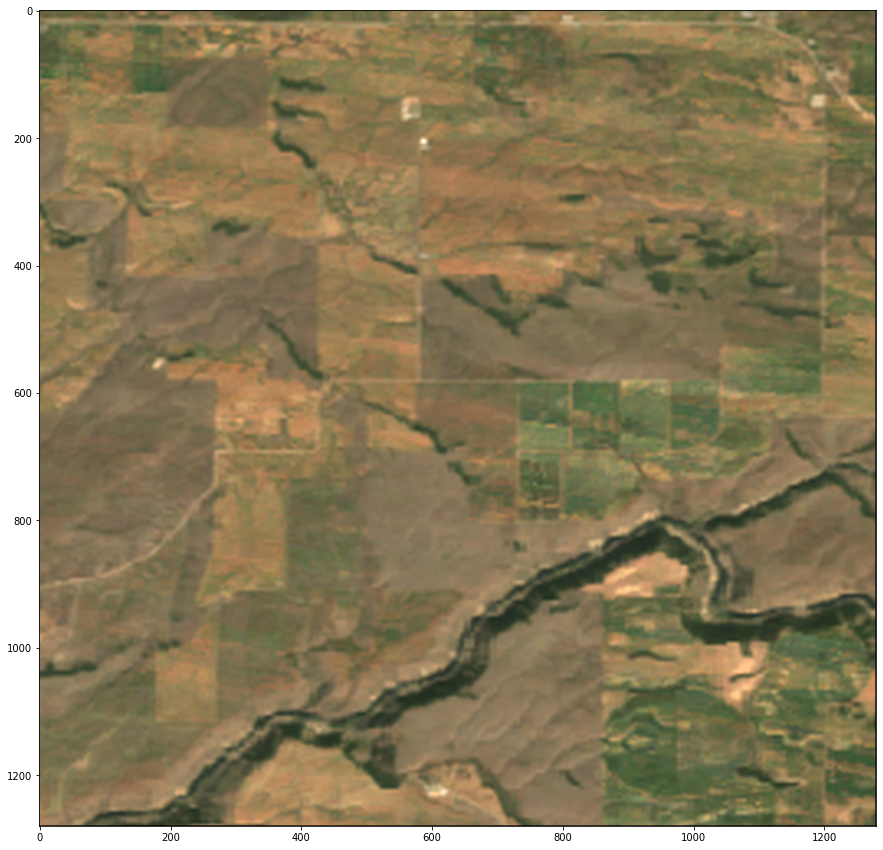

In [14]:
#increase image contrast
CONTRAST_FACTOR = int(5)
blue = image_arrays['B1'] * CONTRAST_FACTOR 
green = image_arrays['B2'] * CONTRAST_FACTOR
red = image_arrays['B3'] * CONTRAST_FACTOR

rgb = np.dstack((red, green, blue))

#Convert image to RGBA (add brightness as a 4th channel)
#Not needed in this example
# rgba = np.insert(
#     rgb,
#     3, #position in the pixel value [ r, g, b, a <-index [3]  ]
#     .9, # or 1 if you're going for a float data type as you want the alpha to be fully white otherwise the entire image will be transparent.
#     axis=2, #this is the depth where you are inserting this alpha channel into
# )

fig, ax = plt.subplots(figsize=(15, 15))

#Zoomed in 5X for easier visual inspection
ax.imshow(scipy.ndimage.zoom(rgb, (5, 5, 1)), aspect='auto')




---



---



---



---



---



---



# Data Pipeline Setup


In this section we will get the dataset ready for insertion into a simple neural network model.


WARNING: ONE-HOT encode is not behaving correctly. The result of the model cannot be relied upon. This notebook was setup as a pipeline exposition only.

For models, please check the `model` folder.



In [ ]:


# Create a description of the features.
FEATURES_GMIA = {
    'B1': tf.io.FixedLenFeature([256,256], tf.float32),
    'B2': tf.io.FixedLenFeature([256,256], tf.float32),
    'B3': tf.io.FixedLenFeature([256,256], tf.float32),
    'B4': tf.io.FixedLenFeature([256,256], tf.float32),
    'B5': tf.io.FixedLenFeature([256,256], tf.float32),
    'B7': tf.io.FixedLenFeature([256,256], tf.float32),
    'target': tf.io.FixedLenFeature([], tf.float32)
    # 'aei': tf.io.FixedLenFeature([], tf.float32)
    # 'id': tf.io.FixedLenFeature([], tf.float32)
}

FEATURES_GFSAD = {
    'B1': tf.io.FixedLenFeature([256,256], tf.float32),
    'B2': tf.io.FixedLenFeature([256,256], tf.float32),
    'B3': tf.io.FixedLenFeature([256,256], tf.float32),
    'B4': tf.io.FixedLenFeature([256,256], tf.float32),
    'B5': tf.io.FixedLenFeature([256,256], tf.float32),
    'B7': tf.io.FixedLenFeature([256,256], tf.float32),
    'landcover': tf.io.FixedLenFeature([256,256], tf.float32)
    # 'id': tf.io.FixedLenFeature([], tf.float32)
}

def _parse_function_gmia(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, FEATURES_GMIA)
    labels = parsed_features.pop('target')
    labels = labels * 100
    return parsed_features, tf.cast(labels, tf.float32)


def _parse_function_gfsad(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, FEATURES_GFSAD)
    labels = parsed_features.pop('landcover')
    return parsed_features, labels



<ParallelMapDataset shapes: ({B1: (256, 256), B2: (256, 256), B3: (256, 256), B4: (256, 256), B5: (256, 256), B7: (256, 256)}, ()), types: ({B1: tf.float32, B2: tf.float32, B3: tf.float32, B4: tf.float32, B5: tf.float32, B7: tf.float32}, tf.float32)>


In [ ]:
def transpose_features(features, label):
  """Function to convert  tuple of (inputs_dict, outputs) into Keras compatible 
  feature tensors of shape (image_height, image_width, color_channels)
  Coverts label to one hot encoding
  Args:
    inputs: Tuple of (input_dict, output).
  Returns: 
    A Keras compatible (inputs, outputs).
  """
  inputsList = [features.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  oh_label = tf.one_hot(indices= tf.cast(label,tf.int32), depth=NCLASSES)

  return stacked, oh_label

In [ ]:
pattern = 'gs://' + GCP_BUCKET + '/' + FOLDER + '/' + TRAIN_PREFIX + '*'
train_files = tf.io.gfile.glob(pattern)
shuffle(train_files)
print(len(train_files))

38


In [ ]:
pattern = 'gs://' + GCP_BUCKET + '/' + FOLDER + '/' + TRAIN_PREFIX + '*'
dataset = tf.data.TFRecordDataset(train_files, compression_type='GZIP')
parsed_dataset = dataset.map(_parse_function_gmia, num_parallel_calls=9)
print(parsed_dataset)

<ParallelMapDataset shapes: ({B1: (256, 256), B2: (256, 256), B3: (256, 256), B4: (256, 256), B5: (256, 256), B7: (256, 256)}, ()), types: ({B1: tf.float32, B2: tf.float32, B3: tf.float32, B4: tf.float32, B5: tf.float32, B7: tf.float32}, tf.float32)>


In [ ]:
# pprint(iter(parsed_dataset).next())

In [ ]:
def normalizedDifference(a, b):
  """Compute normalized difference of two inputs.

  Compute (a - b) / (a + b).  If the denomenator is zero, add a small delta.  

  Args:
    a: an input tensor with shape=[1]
    b: an input tensor with shape=[1]

  Returns:
    The normalized difference as a tensor.
  """
  nd = (a - b) / (a + b)
  nd_inf = (a - b) / (a + b + EPSILON)
  return tf.where(tf.math.is_finite(nd), nd, nd_inf)

def addNDVI(features, label):
  """Add NDVI to the dataset.
  Args: 
    features: a dictionary of input tensors keyed by feature name.
    label: the target label
  
  Returns:
    A tuple of the input dictionary with an NDVI tensor added and the label.
  """
  features['NDVI'] = normalizedDifference(features['B5'], features['B4'])
  return features, label

def addNDWI(features, label):
  features['NDWI'] = normalizedDifference(features['B2'], features['B4'])
  return features, label

def addNDMI(features, label):
  features['NDMI'] = normalizedDifference(features['B4'], features['B5'])
  return features, label

def addMNDWI(features, label):
  features['MNDWI'] = normalizedDifference(features['B2'], features['B5'])
  return features, label

def addWRI(features, label):
    def calcWRI(g, r, nir, mir):
        wri = (g - r)/(nir + mir)
        wri_inf = (g - r)/(nir + mir + EPSILON)
        return tf.where(tf.math.is_finite(wri), wri, wri_inf)
    features['WRI'] = calcWRI(features['B2'], features['B3'], features['B4'], features['B5'])
    return features, label

In [ ]:
full_dataset = parsed_dataset.map(addNDVI)\
                              .map(addNDWI)\
                              .map(addNDMI)\
                              .map(addMNDWI)\
                              .map(addWRI)

FEATURES = BANDS + ['NDVI', 'NDWI', 'NDMI', 'MNDWI', 'WRI']
pprint(iter(full_dataset).next())

({'B1': <tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[0.0631 , 0.05805, 0.0631 , ..., 0.0595 , 0.0534 , 0.0612 ],
       [0.059  , 0.061  , 0.0631 , ..., 0.0517 , 0.05355, 0.0575 ],
       [0.0673 , 0.0693 , 0.0844 , ..., 0.0519 , 0.0541 , 0.053  ],
       ...,
       [0.0427 , 0.04   , 0.0406 , ..., 0.0465 , 0.0408 , 0.0427 ],
       [0.0409 , 0.0387 , 0.036  , ..., 0.0483 , 0.0484 , 0.0465 ],
       [0.0435 , 0.0371 , 0.036  , ..., 0.0455 , 0.0453 , 0.04645]],
      dtype=float32)>,
  'B2': <tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[0.07785, 0.0714 , 0.0675 , ..., 0.0719 , 0.0694 , 0.0747 ],
       [0.0707 , 0.072  , 0.0787 , ..., 0.0654 , 0.0678 , 0.0743 ],
       [0.0811 , 0.0833 , 0.099  , ..., 0.0676 , 0.0665 , 0.0642 ],
       ...,
       [0.0567 , 0.0521 , 0.0533 , ..., 0.0566 , 0.0566 , 0.0543 ],
       [0.0549 , 0.04845, 0.0503 , ..., 0.052  , 0.0566 , 0.0584 ],
       [0.0567 , 0.0515 , 0.0539 , ..., 0.05725, 0.0542 , 0.05535]],
      dtype=flo

In [ ]:
print(full_dataset)
print(FEATURES)

<MapDataset shapes: ({B1: (256, 256), B2: (256, 256), B3: (256, 256), B4: (256, 256), B5: (256, 256), B7: (256, 256), NDVI: (256, 256), NDWI: (256, 256), NDMI: (256, 256), MNDWI: (256, 256), WRI: (256, 256)}, ()), types: ({B1: tf.float32, B2: tf.float32, B3: tf.float32, B4: tf.float32, B5: tf.float32, B7: tf.float32, NDVI: tf.float32, NDWI: tf.float32, NDMI: tf.float32, MNDWI: tf.float32, WRI: tf.float32}, tf.float32)>
['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'NDVI', 'NDWI', 'NDMI', 'MNDWI', 'WRI']


In [ ]:
def transpose_features(features, label):
  """Function to convert  tuple of (inputs_dict, outputs) into Keras compatible 
  feature tensors of shape (image_height, image_width, color_channels)
  Coverts label to one hot encoding
  Args:
    inputs: Tuple of (input_dict, output).
  Returns: 
    A Keras compatible (inputs, outputs).
  """
  inputsList = [features.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  oh_label = tf.one_hot(indices= tf.cast(label,tf.int32), depth=NCLASSES)

  return stacked, oh_label

In [ ]:
final_dataset = full_dataset.map(transpose_features, num_parallel_calls=5)
final_dataset = final_dataset.batch(BATCH_SIZE).repeat()

In [ ]:
# TEST_PREFIX = 'train_US_HI'
# TEST_SIZE = 108

t_pattern = 'gs://' + GCP_BUCKET + '/' + FOLDER + '/' + TEST_PREFIX + '*'
tf.io.gfile.glob(t_pattern)

['gs://w210gee_data/tensors/test_US_EQ_0.tfrecord.gz',
 'gs://w210gee_data/tensors/test_US_EQ_1.tfrecord.gz']

In [ ]:
t_pattern = 'gs://' + GCP_BUCKET + '/' + FOLDER + '/' + TEST_PREFIX + '*'
t_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(t_pattern), compression_type='GZIP')
t_parsed_dataset = t_dataset.map(_parse_function_gmia, num_parallel_calls=9)
# print(parsed_dataset)
t_full_dataset = t_parsed_dataset.map(addNDVI)\
                              .map(addNDWI)\
                              .map(addNDMI)\
                              .map(addMNDWI)\
                              .map(addWRI)

t_final_dataset = t_full_dataset.map(transpose_features, num_parallel_calls=5)
t_final_dataset = t_final_dataset.batch(BATCH_SIZE).repeat()
print(t_final_dataset)

<RepeatDataset shapes: ((None, 256, 256, 11), (None, 6)), types: (tf.float32, tf.float32)>




---



---



---



---



---



---



# Model : Proof of Pipeline Functioning 

    - Experimental Model Setup and Training


In [ ]:


model = models.Sequential()
# input = Input(shape=[256,256,13], batch_size=1)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256,256,len(FEATURES))))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(2056, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 64)      6400      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 512)      

In [ ]:
SAVE_DIR = 'gs://' + GCP_BUCKET + '/' + 'model' + '/' +'gmia_cp.ckpt'

model.compile(optimizer=tf.keras.optimizers.Adam(
                        learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_DIR,
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(x=final_dataset, epochs=10,
          steps_per_epoch=int(TRAIN_SIZE/BATCH_SIZE),
          callbacks=[cp_callback],        
          validation_data=t_final_dataset,
          validation_steps=TEST_SIZE
          )

Train for 1068 steps, validate for 600 steps
Epoch 1/10
1067/1068 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.8386
Epoch 00001: saving model to gs://w210gee_data/model/gmia_cp.ckpt
1068/1068 [==============================] - 478s 448ms/step - loss: 0.7813 - accuracy: 0.8387 - val_loss: 0.5145 - val_accuracy: 0.8333
Epoch 2/10
1067/1068 [============================>.] - ETA: 0s - loss: 0.7701 - accuracy: 0.8395
Epoch 00002: saving model to gs://w210gee_data/model/gmia_cp.ckpt
1068/1068 [==============================] - 475s 445ms/step - loss: 0.7703 - accuracy: 0.8397 - val_loss: 0.5145 - val_accuracy: 0.8333
Epoch 3/10
1067/1068 [============================>.] - ETA: 0s - loss: 0.7657 - accuracy: 0.8395
Epoch 00003: saving model to gs://w210gee_data/model/gmia_cp.ckpt
1068/1068 [==============================] - 476s 445ms/step - loss: 0.7650 - accuracy: 0.8397 - val_loss: 0.5145 - val_accuracy: 0.8333
Epoch 4/10
1067/1068 [============================>.

# SCRATCH PAD

In [ ]:
cen_cal_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA')\
            .filterDate('2005-01-01','2005-12-31')\
            .filterBounds(cen_cal.first().geometry())\
            .mosaic()\
            .select(['B3','B4','B5', 'B8'])

In [ ]:
train_db = cen_cal_img.sampleRegions(collection=cen_cal, 
                                 properties=['ID','bins'],
                                 scale=30,
                                 projection='EPSG:4326',
                                 tileScale=2
                                 )

In [ ]:
pprint({'training': train_db.first().getInfo()})

{'training': {'geometry': None,
              'id': '0005000000000000119a_0',
              'properties': {'B3': 0.03720364719629288,
                             'B4': 0.016949230805039406,
                             'B5': 0.0003108411037828773,
                             'B8': 0.04263530671596527,
                             'ID': 174075,
                             'bins': 0},
              'type': 'Feature'}}


In [ ]:
trainingTask = ee.batch.Export.table.toCloudStorage(**
                {'collection':train_db,
                'description':'Training Export',
                'fileNamePrefix': 'cal_1',
                'bucket':GCP_BUCKET,
                'fileFormat':'TFRecord'
                })

trainingTask.start()

In [ ]:
while trainingTask.active():
  print('Polling for task (id: {}).'.format(trainingTask.id))
  sleep(30)

print('Done!')

Polling for task (id: YJRDT34DXZNSXMZCK4ZZ7UI3).
Done!


In [ ]:

pprint(trainingTask.status())

{'creation_timestamp_ms': 1582685925687,
 'description': 'Training Export',
 'destination_uris': ['https://console.developers.google.com/storage/browser/w210gee_data/'],
 'id': 'YJRDT34DXZNSXMZCK4ZZ7UI3',
 'name': 'projects/earthengine-legacy/operations/YJRDT34DXZNSXMZCK4ZZ7UI3',
 'start_timestamp_ms': 1582685934531,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_FEATURES',
 'update_timestamp_ms': 1582685948850}


In [ ]:
# Image(url = cen_cal_img.getThumbUrl({'bands':['B5','B4','B3'], 
#                                 'min': 0, 
#                                 'dimensions': '512x512', 
#                                 }))

In [ ]:
# cen_cal.get(0).getInfo()['properties']['ID']
eefeature_list = []
list_cen_cal = cen_cal.toList(cen_cal.size())
for feat in range(cen_cal.size().getInfo()):
    eefeature_list.append(ee.Feature(ee.Geometry.Polygon(list_cen_cal.get(feat).getInfo()['geometry']['coordinates'])))
    print(list_cen_cal.get(feat).getInfo()['properties']['bins'])
# ee.FeatureCollection(ee.Feature(list_cen_cal.get(0))).getInfo()
# .properties['ID']
cal_feats = ee.FeatureCollection(ee.List(eefeature_list)) #.getInfo()

0
0


In [ ]:
cen_cal_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA')\
            .filterDate('2005-01-01','2005-12-31')\
            .filterBounds(cal_feats.first().geometry())\
            .mosaic()\
            .select(['B3','B4','B5', 'B8'])

In [ ]:
train_db = cen_cal_img.sampleRegions(collection=cal_feats, 
                                 properties=['ID','bins'],
                                 scale=30,
                                 projection='EPSG:4326',
                                 tileScale=2
                                 )
pprint({'training': train_db.first().getInfo()})

{'training': {'geometry': None,
              'id': '0_0',
              'properties': {'B3': 0.07166144251823425,
                             'B4': 0.1810581386089325,
                             'B5': 0.1246926486492157,
                             'B8': 0.13642291724681854},
              'type': 'Feature'}}


In [ ]:
cen_cal_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA')\
            .filterDate('2005-01-01','2005-12-31')\
            .filterBounds(cen_cal.first().geometry().getInfo())\
            .mosaic()\
            .select(['B3','B4','B5', 'B8'])


for idx in range(cen_cal.size().getInfo()):
    id = list_cen_cal.get(idx).getInfo()['properties']['ID']

    train_db = cen_cal_img.sampleRegions(#collection=ee.FeatureCollection(
                                         #              ee.Feature(list_cen_cal.get(idx))
                                         #                               ) , 
                                        collection=cen_cal,
                                        properties=['ID','bins'],
                                        scale=30,
                                        projection='EPSG:4326'
                                         tileScale=10
                                        )
    pprint({'training': train_db.first().getInfo()})
    
    trainingTask = ee.batch.Export.table.toCloudStorage(**
                    {'collection':train_db,
                    'description':'Training Export',
                    'fileNamePrefix': str(id)
                    'bucket':GCP_BUCKET,
                    'fileFormat':'TFRecord'
                    })
    
    trainingTask.start()

{'training': {'geometry': None,
              'id': '0005000000000000119a_0',
              'properties': {'B3': 0.03720364719629288,
                             'B4': 0.016949230805039406,
                             'B5': 0.0003108411037828773,
                             'B8': 0.04263530671596527,
                             'ID': 174075,
                             'bins': 0},
              'type': 'Feature'}}


In [ ]:
print(trainingTask.status())

{'state': 'FAILED', 'description': 'Training Export', 'creation_timestamp_ms': 1582533099372, 'update_timestamp_ms': 1582533177952, 'start_timestamp_ms': 1582533172594, 'task_type': 'EXPORT_FEATURES', 'error_message': 'Internal error.', 'id': 'J7INKKZJNR6FASNEYUXKFRYW', 'name': 'projects/earthengine-legacy/operations/J7INKKZJNR6FASNEYUXKFRYW'}


In [ ]:
cen_cal_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA')\
            .filterDate('2005-01-01','2005-12-31')\
            .filterBounds(cen_cal.first().geometry().getInfo())\
            .mosaic()\
            .select(['B3','B4','B5', 'B8'])


for idx in range(cen_cal.size().getInfo()):
    id = list_cen_cal.get(idx).getInfo()['properties']['ID']

    train_db = cen_cal_img.sampleRegions(collection=ee.FeatureCollection(ee.Feature(ee.Geometry.Polygon(list_cen_cal.get(idx).getInfo()['geometry']['coordinates']))) , 
                                        properties=['ID','bins'],
                                        scale=30,
                                        projection='EPSG:4326'
                                        #  tileScale=8
                                        )
    
    trainingTask = ee.batch.Export.table.toCloudStorage(
                    collection=train_db,
                    description='Training Export',
                    fileNamePrefix=str(id) + '_',
                    bucket=GCP_BUCKET,
                    fileFormat='TFRecord')
    
    trainingTask.start()

In [ ]:
 trainingTask.status()

{'creation_timestamp_ms': 1582531788214,
 'description': 'Training Export',
 'id': '67BF2TNA6T2ZJBJRM6PKE4BH',
 'name': 'projects/earthengine-legacy/operations/67BF2TNA6T2ZJBJRM6PKE4BH',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_FEATURES',
 'update_timestamp_ms': 1582531788214}

In [ ]:
while trainingTask.active():
  print('Polling for task (id: {}).'.format(trainingTask.id))
  sleep(30)

print('Done!')

Polling for task (id: 3KV3M4P7JPGA6WVOXQUMV4QT).
Polling for task (id: 3KV3M4P7JPGA6WVOXQUMV4QT).


KeyboardInterrupt: ignored

In [ ]:
# while trainingTask.active():
#   print('Polling for task (id: {}).'.format(trainingTask.id))
#   sleep(30)

# print('Done!')

In [ ]:

# us_states = ee.FeatureCollection('TIGER/2018/States')

In [ ]:

# nj = us_states.filter(ee.Filter.eq('STUSPS','NJ')).getInfo()
# print(nj['features'][0]['geometry'])

In [ ]:
# train_agriculture = ee.FeatureCollection('users/csaybar/DLdemos/train_set') 
# test_agriculture = ee.FeatureCollection('users/csaybar/DLdemos/test_set')

# jamaica = ee.FeatureCollection('users/montyhallgoat/gmia/gmia_final').filter(ee.Filter.eq('name','Jamaica'))
# jamaica = gmia
# print(jamaica.size().getInfo())
# users/montyhallgoat/gmia/gmia_final


# pprint(jamaica.getInfo())

In [ ]:

# jam_img = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA')\
#             .filterDate('2004-01-01','2007-12-31')\
#             .filterBounds(jamaica)\
#             .mosaic()\
#             .select(['B3','B4','B5', 'B8'])



In [ ]:
# b1scale = img_array.select('B1').projection().nominalScale()
# print('Band 1 scale: \n', int(b1scale.getInfo()))

In [ ]:

# Image(url = jam_img.getThumbUrl({'bands':['B5','B4','B3'], 
#                                 'min': 0, 
#                                 'dimensions': '512x512', 
#                                 }))

# jam_img.getInfo()

In [ ]:

# train_db = jam_img.sampleRegions(collection=jamaica, 
#                                  properties=['ID','bins'],
#                                  scale=60,
#                                  projection='EPSG:4326',
#                                  tileScale=8)

In [ ]:
# Print the first couple points to verify.
# pprint({'training': train_db.first().getInfo()})

In [ ]:
# driveTask = ee.batch.Export.table.toDrive(**{
#   'collection': train_db,
#   'folder': DRIVE_OUTPUT_FOLDER,
#   'description':'Training Export',
#   'fileNamePrefix':trainFilePrefix,
#   'fileFormat': 'TFRecord'
# })
# driveTask.start()

In [ ]:
# while driveTask.active():
#   print('Polling for task (id: {}).'.format(driveTask.id))
#   sleep(5)

# print('Done!')

In [ ]:
# print(driveTask.status())

In [ ]:
# print(driveTask.status())

In [ ]:
# if tf.io.gfile.exists(GCP_BUCKET):
#     print('Found Cloud Storage bucket. {}'.format(GCP_BUCKET))  
# else:
#     print('Output Cloud Storage bucket does not exist.')

# trainFilePrefix = 'JAM_'
# testFilePrefix = 'Test_'
# # imageExportFormatOptions = {
# #   'patchDimensions': [64, 64],  
# #   'maxFileSize': 100000000,    
# #   'compressed': True
# # }
# # Create the tasks for passing of GEE to Google storage
# trainingTask = ee.batch.Export.table.toCloudStorage(**
#   {
#   'collection':train_db,
#   'description':'Training Export',
#   'fileNamePrefix':trainFilePrefix,
#   'bucket':GCP_BUCKET,
#   'fileFormat':'TFRecord'
#   })

# trainingTask.start()

In [ ]:

# print(trainingTask.status())

In [ ]:

# trainingTask.cancel()